# From Chaos to Cloud: How I Taught a Friendly AI to Speak TOSCA

A conversational AI system that helps users create properly formatted TOSCA (Topology and Orchestration Specification for Cloud Applications) files through an interactive dialogue.

## Overview

In today's cloud-native world, deploying and managing applications across different cloud platforms has become increasingly complex. While cloud systems are becoming more popular, many developers and system administrators struggle with the technical complexities of cloud orchestration and deployment automation. TOSCA (Topology and Orchestration Specification for Cloud Applications) provides a standardized way to describe cloud applications, but creating these files manually can be challenging and error-prone.

This project implements a conversational AI system using Google's Generative AI (Gemini) to guide users through the process of creating TOSCA files. The system uses a state graph architecture to manage the conversation flow and ensure all required fields are properly filled out. By providing an intuitive, conversational interface, this tool makes it easier for users to generate accurate TOSCA files without deep knowledge of the specification.

## GenAI Features Used

This project leverages several advanced GenAI capabilities:

- **Structured Output/JSON Mode**: The system uses structured output generation to create properly formatted TOSCA JSON files
- **Function Calling**: Implements tool calling for file saving operations
- **Agents**: Uses a state graph architecture with specialized nodes (chatbot, converter, human, tool) to manage the conversation flow
- **Few-shot Prompting**: Includes example TOSCA files in the system prompts to guide the generation process
- **Long Context Window**: Maintains conversation history and context throughout the file generation process
- **Document Understanding**: Processes and understands TOSCA specifications and requirements

## Features

- Interactive conversation-based TOSCA file generation
- Step-by-step guidance through all required fields
- Validation of input data against TOSCA specifications
- Automatic JSON file generation and saving
- Support for metadata, nodes, and virtual links configuration

## Prerequisites

- Python 3.9+
- Google Generative AI API key
- Required Python packages:
  - google-generativeai
  - langgraph
  - langchain-google-genai
  - fsspec
  - async-timeout

## Installation

1. Clone this repository
2. Install required packages:

```bash
pip install -qU 'fsspec==2024.10.0' 'async-timeout==4.0.3' 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' "google-genai==1.7.0"
```

3. Set up your Google API key:

```python
GOOGLE_API_KEY = "your-api-key-here"
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
```

## Usage

1. Open the Jupyter notebook `gen-ai-intensive-course-capstone-2025q1.ipynb`
2. Run all cells to initialize the system
3. To start the conversation flow defined in the state graph, you can uncomment the following line in the last cell:
```python
# state = chat_with_human_graph.invoke({"messages": []}, config)
```
4. The system will guide you through creating a TOSCA file by asking questions about:

   - Metadata fields
   - Number of nodes
   - Node properties, capabilities, and connections
   - Number of virtual links
   - Virtual link details
5. If you want to observe the functionality without engaging in a full conversation, you can copy and paste a conversation text (available in the last cell) into the input box after initiating the chat.
6. The generated TOSCA file will be automatically saved as a JSON file with a timestamp in `/kaggle/working`.


## Project Structure

The project uses a state graph architecture with the following components:

- **Chatbot Node**: Handles the conversation with the user
- **Converter Node**: Converts the conversation into properly formatted JSON
- **Human Node**: Manages user input
- **Tool Node**: Handles file saving operations

## TOSCA File Structure

The system supports the following TOSCA file structure:

- **Metadata**:

  - tosca_definitions_version
  - description
  - template_name
  - template_author
  - template_version
  - imports

- **Nodes**:

  - Properties (name, deployment_unit, image, etc.)
  - Capabilities (CPU, RAM)
  - Connections

- **Virtual Links**:
  - Name
  - Bandwidth
  - Latency
  - Jitter
  - Connected nodes

## License

This project is part of the GenAI Intensive Course Capstone 2025Q1.

## Acknowledgments

- Google Generative AI
- LangGraph
- LangChain


In [20]:
# Initialization

# Remove conflicting packages from the Kaggle base environment.
# Using -qqy flags: -qq for very quiet output, -y for automatic yes to prompts
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-generativeai

# Install langgraph and the required packages.
# Using -qU flags: -q for quiet output, -U to upgrade packages if already installed
# fsspec: filesystem interface package for handling various storage systems
# async-timeout: provides timeout functionality for async operations
# langgraph: framework for building language model applications as graphs
# langchain-google-genai: integration between LangChain and Google's Generative AI
# langgraph-prebuilt: collection of prebuilt components for langgraph
# google-genai: official Google Generative AI Python client
!pip install -qU 'fsspec==2024.10.0' 'async-timeout==4.0.3' 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' "google-genai==1.7.0"

In [21]:
# Imports

# Operating system interfaces
import os
# For accessing Kaggle secrets (API keys)
from kaggle_secrets import UserSecretsClient
# Google Generative AI API client
from google import genai
# Message handling for LangGraph
from langgraph.graph.message import add_messages
# Tool decorator for creating callable tools
from langchain_core.tools import tool
# Core LangGraph components for building the conversation flow
from langgraph.graph import StateGraph, START, END
# Google Generative AI integration with LangChain
from langchain_google_genai import ChatGoogleGenerativeAI
# AI message type for structured responses
from langchain_core.messages.ai import AIMessage
# Pre-built tool node for LangGraph
from langgraph.prebuilt import ToolNode
# Type hinting utilities
from typing import Annotated, Literal  
# Extended typing utilities for custom type definitions
from typing_extensions import TypedDict
# Image display functionality for notebooks
from IPython.display import Image
# JSON handling for structured data
import json  
# Date and time utilities
from datetime import datetime 

# Configuration settings to prevent infinite recursion
config = {"recursion_limit": 200}

In [22]:
# API Setup and Authentication

# Check the version of Google's Generative AI library
print(f"GenAI Version: {genai.__version__}")

# Retrieve the Google API key from Kaggle secrets and set it as an environment variable
# This is a secure way to access the API without hardcoding credentials
try:  
    # Get the API key from Kaggle's secret manager
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")  
    # Set it as an environment variable for the Google GenAI library to use
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    # Uncomment to debug (not recommended in production as it exposes the key)
    # print(GOOGLE_API_KEY)
    
    # Verify that we successfully retrieved a non-empty API key
    if GOOGLE_API_KEY:  
        print("GOOGLE_API_KEY is imported!")  
    else:  
        print("GOOGLE_API_KEY exists but is empty!")  
        
except Exception as e:  
    # Handle any errors that might occur during API key retrieval
    print(f"Error retrieving GOOGLE_API_KEY: {e}")  

# Initialize the Google GenAI client with our API key
# This client will be used for all interactions with Google's generative AI models
client = genai.Client(api_key=GOOGLE_API_KEY)

GenAI Version: 1.7.0
GOOGLE_API_KEY is imported!


In [23]:
# TOSCA File Structure Definition

# Define the structure of a TOSCA (Topology and Orchestration Specification for Cloud Applications) file
# This dictionary specifies all required and optional fields with their types and constraints
format = {
    "metadata": {
        "tosca_definitions_version": "string",
        "description": "string",
        "template_name": {
            "type": "string",
            "required": True
        },
        "template_author": {
            "type": "string",
            "required": True
        },
        "template_version": {
            "type": "string",
            "required": True
        },
        "imports": {
            "type": "string of file names seperated by comma",
            "required": False
        }
    },
    "nodes": {
        "type": "list",
        "required": True,
        "properties": {
            "name": {
                "type": "string",
                "required": True
            },
            "deployment_unit": {
                "type": "string",
                "required": True,
                "constraints": [
                        {"valid_values": ["VM", "K8S_POD"]}
                ]
            },
            "image": {
                "type": "string",
                "required": True
            },
            "placement_hint": {
                "type": "string",
                "required": True,
                "constraints": [
                        {"valid_values": ["EDGE", "CLOUD"]}
                ]
            },
            "environment": {
                "type": "string of key:value pairs seperated by comma",
                "required": False,
                "default": {
                    "NODE_ENV: { get_input: NODE_ENV }"
                }
            },
            "replicas": {
                "type": "integer",
                "required": False,
                "default": 1
            },
        },
        "capabilities": {
            "cpu": {
                "type": "string",
                "required": True,
                "constraints": [
                    {"equal": "Specify an exact CPU value."},
                    {"greater_or_equal": "Specify the minimum acceptable CPU value."},
                    {"less_than": "Specify the maximum acceptable CPU value."},
                    {"greater_than": "Specify the minimum acceptable CPU value."},
                    {"less_or_equal": "Specify the maximum acceptable CPU value (less than or equal)."}
                ]
            },
            "ram": {
                "type": "string",
                "required": True,
                "constraints": [
                    {"equal": "Specify an exact RAM value."},
                    {"greater_or_equal": "Specify the minimum acceptable RAM value."},
                    {"less_than": "Specify the maximum acceptable RAM value."},
                    {"greater_than": "Specify the minimum acceptable RAM value."},
                    {"less_or_equal": "Specify the maximum acceptable RAM value (less than or equal)."}
                ]
            }
        },
        "connection": {
            "name": {
                "type": "string",
                "required": True
            },
            "port": {
                "type": "integer",
                "required": False
            },
            "protocol": {
                "type": "string",
                "required": False,
                "constraints": [
                    {"valid_values": ["TCP", "UDP"]}
                ]
            },
            "public": {
                "type": "bool",
                "required": False
            }
        },
    },
    "virtual links": {
        "type": "list",
        "required": True,
        "name": {
            "type": "string",
            "required": True
        },
        "bandwidth": {
            "type": "string",
            "required": True,
            "constraints": [
                {"pattern": "[0-9]+ Mbps"}
            ]
        },
        "latency": {
            "type": "string",
            "required": True,
            "constraints": [
                {"pattern": "[0-9]+ ms"}
            ]
        },
        "jitter": {
            "type": "string",
            "required": True,
            "constraints": [
                {"pattern": "[0-9]+ ms"}
            ]
        },
        "nodes": {
            "type": "string of node names seperated by comma",
            "required": True
        }
    }
}

# Provide a sample TOSCA file as an example for reference
# This demonstrates how the format should be populated with actual values
example = {
    "metadata": {
        "tosca_definitions_version": "tosca_simple_yaml_1_3",
        "description": "ssss",
        "template_name": "voting-app",
        "template_author": "developer",
        "template_version": "",
        "imports": "MIRO_custom_types_v08.yaml, MIRO_custom_types_v10.yaml"
    },

    "nodes": [
        {
            "properties": {
                "name": "redis",
                "deployment_unit": "K8S_POD",
                "image": "redis:alpine",
                "placement_hint": "CLOUD",
                "replicas": 1,
                "environment": "NODE_ENV: { get_input: NODE_ENV }"
            },
            "capabilities": {
                "cpu": "equal: 200",
                "ram": "equal: 1024",
            },
            "connection": {
                "name": "redis_cp",
                "port": 6379,
                "protocol": "TCP",
                "public": False
            },
        },
        {
            "properties": {
                "name": "worker",
                "deployment_unit": "K8S_POD",
                "image": "dockersamples/examplevotingapp_worker",
                "placement_hint": "CLOUD",
                "replicas": 1,
                "environment": "POSTGRES_USER: postgres, POSTGRES_PASSWORD: postgres"
            },
            "capabilities": {
                "cpu": "equal: 150",
                "ram": "equal: 1024",
            },
            "connection": {
                "name": "worker_cp",
            },
        },
    ],
    "virtual links": [
        {
            "name": "VL1",
            "bandwidth": "50 Kbps",
            "latency": "5 ms",
            "jitter": "100 ms",
            "nodes": "redis, worker"
        },
        {
            "name": "VL2",
            "bandwidth": "0 Kbps",
            "latency": "10000 ms",
            "jitter": "100 ms",
            "nodes": "redis, worker"
        }
    ]
}


In [24]:
# Messages and State Management

# TypedDict for maintaining conversation state
class RequestState(TypedDict):
    """State representing the user's request conversation."""

    # The chat conversation history between the user and the model.
    # The `add_messages` annotation indicates to LangGraph that state is updated by appending returned messages, not replacing them.
    messages: Annotated[list, add_messages]

    # The user's in-progress request data.
    request: list[str]

    # Flag indicating that the request is completed.
    finished: bool

# The general system message for the chatbot inspector
# Includes rules for conversation flow and TOSCA file structure guidance
CHATBOT_SYS_MSG = f"""
You are an inspector helping users fill out a form.
Retrieve the fields in the initial step and their formats from <FORMAT>.
Check the message history and ask one question at a time to fill each remianing field.

THE STEPS ARE AS FOLLOWS:
1. Ask about the fields in metadata.
2. Ask about the number of nodes.
3. Ask about the properties of each node, including properties, capabilities, and connection
4. Ask about the number of virtual links.
5. Ask about the details of each virtual link. When asking about the list of nodes the link is connected to, provide the list of registered nodes in the question, and dot NOT accept any name except the ones in the list.
Note: If the user wishes to make a correction for the previous fileds, assist them and then continue with the remaining fields.

QUESTION FORMAT RULES:
- Ask exactly ONE question at a time about the next required field. Dont ask about a set of fields in one question. Ask about fields one by one.
- Questions should be clear and concise.
- Specify if the field is mandatory or optional. If the field is optinoal, tell users they can inout "none".
- If there is any default or valid value for the field, include it in the question. 
- Compare the user's responses with the default or valid values and also accept similar answers. For example:  
    -- "vm" is acceptable when "VM" is an option.  
    -- The same applies to "edge" and "Edge."  
    -- A "maximum 1000" is acceptable when we intend to specify "less_than: 1000".

COMPLETION CHECK:
- When all required fields are filled, you must respond with the single word "DONE" (in uppercase) with no punctuation, no additional text, and no extra whitespace.
- You must verify ALL fields are filled before responding with "DONE".
- ANY missing field means the form is incomplete.
- NEVER output "DONE" unless the form is 100% complete.
- DO BOT RETURN THE CREATED FORM TO THE USER. JUST RETURN DONE.

<FORMAT>
{format}
</FORMAT>
"""

# Welcome message displayed to the user at the start of the conversation
WELCOME_MSG = """
I am an inspector helping users fill out a TOSCA file. 
I will ask you questions about the fields in the file to ensure it is complete and correctly formatted. 
Ready to start?
"""

# System message for the converter component
# Provides instructions for formatting the collected data into proper JSON
CONVERTER_SYS_MSG= f"""
You are a text formatter with a specific workflow. Follow these steps in sequence: 1) generate a string JSON, 2) save the generated string.

Convert the input messages into properly formatted JSON string. Refer to <EXAMPLE> to obtain the desired structure.
Apply these specific formatting rules:  
* Return the CPU and RAM values in the format of "XXX : <value>", where XXX should be one of these constraints:
-- equal: Specify an exact CPU value.
-- greater_or_equal: Specify the minimum acceptable CPU value.
-- less_than: Specify the maximum acceptable CPU value.
-- greater_than: Specify the minimum acceptable CPU value.
-- less_or_equal: Specify the maximum acceptable CPU value(less than or equal).
* For environment variables: if default or not specified, use "NODE_ENV: {{ get_input: NODE_ENV }}". 
* For replicas: if not specified or default, use "1".
* For any missing field: fill with "none".

Then, send the extracted JSON string to save_file.  

<EXAMPLE>
{example}
</EXAMPLE>
"""

# Chatbot system instruction for the inspector component
CHATBOT_SYSTEM_INSTRUCTION = (
    "system",  # 'system' indicates the message is a system instruction.
    CHATBOT_SYS_MSG
)

# Converter system instruction for the JSON formatting component
CONVERTER_SYSTEM_INSTRUCTION = (
    "system",  # 'system' indicates the message is a system instruction.
    CONVERTER_SYS_MSG
)

In [25]:
# Tools

@tool
def save_file(json_str: str) -> str:
    """Save the TOSCA file.
    
    This function takes a JSON string, processes it, and saves it to a file with a timestamp.
    
    Args:
        json_str (str): The JSON string to be saved, potentially containing markdown code blocks
        
    Returns:
        str: A confirmation message indicating successful save
    """
    # Get current date and time for the filename to make each save unique
    current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  
    
    # Clean the JSON string by removing markdown code block indicators
    # This handles cases where the LLM wraps JSON in ```json ... ``` format
    cleaned_json_str = json_str.replace("```json", "").replace("```", "")  
    
    # Parse the cleaned string to a Python dictionary object
    # This validates that we have proper JSON before saving
    json_data = json.loads(cleaned_json_str)  
    
    # Create a filename with timestamp to avoid overwriting previous files
    filename = f"result_{current_date}.json"  
    
    # Write the JSON data to the file with pretty formatting (indent=4)
    with open(filename, "w") as file:  
        json.dump(json_data, file, indent=4)   

    # Return a success message that will be shown to the user
    return "\nThe JSON file has been successfully saved."

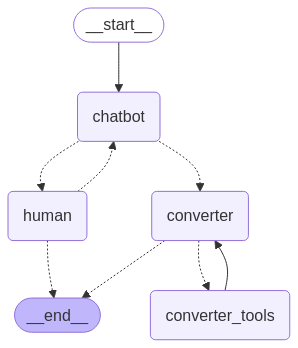

In [26]:
# Agent Graph Definition

# Define the tools and create a tool node for handling file operations
tools = [save_file]  
tool_node = ToolNode(tools)  

# Initialize LLM models - one for general conversation and one for JSON conversion
chatbot_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
converter_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", response_format={"type": "json_object"})

# Attach the tools to the converter model to enable file saving functionality
converter_llm_with_tools = converter_llm.bind_tools(tools)

def human_node(state: RequestState) -> RequestState:
    """Process user input and determine if conversation should continue."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # Check for exit commands to terminate the conversation
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def chatbot_node(state: RequestState) -> RequestState:
    """Handle the conversational part of the application using the Gemini model."""
    if state["messages"]:
        # Continue existing conversation with the Gemini model
        new_output = chatbot_llm.invoke([CHATBOT_SYSTEM_INSTRUCTION] + state["messages"])
    else:
        # Initialize conversation with welcome message
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}

def converter_node(state: RequestState) -> RequestState:
    """Convert conversation data to TOSCA JSON format using the Gemini model."""
    if state["messages"]:
        new_output = converter_llm_with_tools.invoke([CONVERTER_SYSTEM_INSTRUCTION] + state["messages"])
    else:
        print("There are no messages available!") 

    return state | {"messages": [new_output]}

def human_edges(state: RequestState) -> Literal["chatbot", "__end__"]:
    """Route user input to chatbot or end the conversation based on user intent."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

def chatbot_edges(state: RequestState) -> Literal["human", "converter"]:
    """Determine next step based on chatbot response - continue conversation or proceed to conversion."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Analyze the last message to determine routing
    msg = msgs[-1]

    if msg.content.find("DONE") != -1:  
        print("\nThe required information is collected. Wait for the file...")
        return "converter"
    else:
        return "human"

def converter_edges(state: RequestState) -> Literal["converter_tools", "__end__"]:
    """Route converter output to either save the file or end the process."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Analyze the last message to determine routing
    msg = msgs[-1]

    # When the converter has tool calls (file saving), route to the tools node
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "converter_tools"
    else:
        print("\nThe file is saved successfully.")
        return END


# Build the application graph structure
graph_builder = StateGraph(RequestState)

# Add all required nodes to the application graph
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("converter", converter_node)
graph_builder.add_node("human", human_node)
graph_builder.add_node("converter_tools", tool_node)

# Define the flow between nodes with appropriate edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", chatbot_edges)
graph_builder.add_conditional_edges("human", human_edges)
graph_builder.add_conditional_edges("converter", converter_edges)
graph_builder.add_edge("converter_tools", "converter")

# Compile the graph to create the executable application
chat_with_human_graph = graph_builder.compile()

# Visualize the graph structure using Mermaid to display the flow between nodes
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [27]:
# Chat

# This starts the conversation flow defined in our state graph
# This is commented to ensure the successful execution of all cells. 
# Please uncomment it if you wish to engage in conversation.
# state = chat_with_human_graph.invoke({"messages": []}, config)

# You may also copy and paste the following text into the input box after initiating the chat 
# if you wish to observe its functionality but do not have the time to engage in conversation yourself.
    
# User:  Yes
# Model: Okay, let's start with the metadata section.
# First, what is the TOSCA definitions version? (string, mandatory)
# User:  tosca_1_1
# Model: Next, can you provide a description for the template? (string, optional. You can input "none")
# User:  This is a Tosca file to implement my app on a cloud server.
# Model: What is the template name? (string, mandatory)
# User:  tmp_app
# Model: Who is the template author? (string, mandatory)
# User:  Masoud
# Model: What is the template version? (string, mandatory)
# User:  v1
# Model: Are there any import file names? If yes, please provide the file names separated by commas. (string, optional. You can input "none")
# User:  none
# Model: Now, let's move on to the nodes section.
# How many nodes are there? (integer, mandatory)
# User:  1
# Model: Okay, let's define the properties for the first node.
# What is the name of the node? (string, mandatory)
# User:  node1
# Model: What is the deployment unit for node1? (string, mandatory, valid values: VM, K8S_POD)
# User:  vm
# Model: What is the image for node1? (string, mandatory)
# User:  image:node
# Model: What is the placement hint for node1? (string, mandatory, valid values: EDGE, CLOUD)
# User:  cloud
# Model: What is the environment for node1? (string of key:value pairs separated by commas, optional, default: NODE_ENV: { get_input: NODE_ENV }. You can input "none")
# User:  use default
# Model: What is the number of replicas for node1? (integer, optional, default: 1. You can input "none")
# User:  1
# Model: Now, let's define the capabilities for node1.
# What is the CPU capability for node1? (string, mandatory, acceptable values: Specify an exact CPU value, Specify the minimum acceptable CPU value, Specify the maximum acceptable CPU value, Specify the minimum acceptable CPU value, Specify the maximum acceptable CPU value (less than or equal).)
# User:  maximum 1000
# Model: What is the RAM capability for node1? (string, mandatory, acceptable values: Specify an exact RAM value, Specify the minimum acceptable RAM value, Specify the maximum acceptable RAM value, Specify the minimum acceptable RAM value, Specify the maximum acceptable RAM value (less than or equal).)
# User:  minimum 1000
# Model: Now, let's define the connection for node1.
# What is the name of the connection? (string, mandatory)
# User:  con1
# Model: What is the port for con1? (integer, optional. You can input "none")
# User:  none
# Model: What is the protocol for con1? (string, optional, valid values: TCP, UDP. You can input "none")
# User:  tcp
# Model: Is the connection public? (boolean, optional. You can input "none")
# User:  no
# Model: Now, let's move on to the virtual links section.
# How many virtual links are there? (integer, mandatory)
# User:  1
# Model: Okay, let's define the properties for the first virtual link.
# What is the name of the virtual link? (string, mandatory)
# User:  I want 2 virtual links
# Model: Okay, let's move on to the virtual links section.
# I will delete the previous answer.
# How many virtual links are there? (integer, mandatory)
# User:  2
# Model: Okay, let's define the properties for the first virtual link.
# What is the name of the virtual link? (string, mandatory)
# User:  vl1
# Model: What is the bandwidth of vl1? (string, mandatory, format: [0-9]+ Mbps)
# User:  1000 mbps
# Model: What is the latency of vl1? (string, mandatory, format: [0-9]+ ms)
# User:  100 ms
# Model: What is the jitter of vl1? (string, mandatory, format: [0-9]+ ms)
# User:  100 ms
# Model: What are the nodes connected to vl1? (string of node names separated by commas, mandatory. Registered node name: node1)
# User:  node1
# Model: Okay, let's define the properties for the second virtual link.
# What is the name of the virtual link? (string, mandatory)
# User:  vl2
# Model: What is the bandwidth of vl2? (string, mandatory, format: [0-9]+ Mbps)
# User:  10 mbps
# Model: What is the latency of vl2? (string, mandatory, format: [0-9]+ ms)
# User:  1000 ms
# Model: What is the jitter of vl2? (string, mandatory, format: [0-9]+ ms)
# User:  1000 ms
# Model: What are the nodes connected to vl2? (string of node names separated by commas, mandatory. Registered node name: node1)
# User:  node 1
# Model: I'm sorry, but the node name you provided is not valid.
# What are the nodes connected to vl2? (string of node names separated by commas, mandatory. Registered node name: node1)
# User:  node1